In [240]:
import numpy as np
from skimage import io
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fft2, fftshift, dct, idct
from scipy import fftpack
from PIL import Image
import pywt

# Kryterium MAE (Mean Absolute Error) - zawartość informacji

In [241]:
def MAE(image1,image2):
    assert image1.shape == image2.shape, "Obrazy mają różne wielkości"
    return np.mean(np.abs(image1-image2))

# Kryterium zawartości kompresji (C)

In [242]:
def C_ratio(orginal,image):
    bits_org = orginal.dtype.itemsize * 8 * orginal.size
    bits_deco = image.dtype.itemsize * 8 * image.size
    return bits_org / bits_deco
     

# Algorytm kompresji stratnej korzystający z transformacji Fouriera dla obrazów szarych

In [243]:
def compress(image, compression_ratio):
    # Wykonanie dyskretnej transformacji Fouriera
    f_image = np.fft.fft2(image)
    # Posortowanie pixeli według amplitudy
    sort_f_image = np.sort(np.abs(f_image.flatten()))
    # Obliczanie progu, który następnie zostanie wyzerowany
    threshold = sort_f_image[int((1 - compression_ratio) * len(sort_f_image))]
    # Wyzerowanie współczynników, które znajdują się poniżej naszego progu
    f_image[np.abs(f_image) <  threshold] = 0
    # Wykonanie odwrotnej transformacji Fouriera
    return np.fft.ifft2(f_image).real


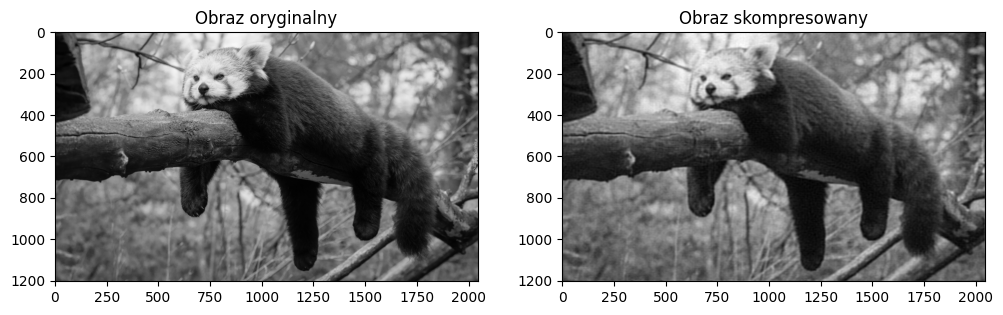

Mean Absolute Error: 0.018022134400319405
Commpression Ratio (C): 1.0


In [244]:
image_gray = io.imread("pandaaa.jpg", as_gray=True)
compressed = compress(image_gray,0.01)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image_gray, cmap="grey")
plt.title("Obraz oryginalny")


plt.subplot(1,2,2)
plt.imshow(compressed, cmap="grey")
plt.title("Obraz skompresowany")
plt.show()
print(f"Mean Absolute Error: {MAE(image_gray,compressed)}")
print(f"Commpression Ratio (C): {C_ratio(image_gray,compressed)}")

W kontekście zróżnicowanych wartości parametru "compression_ratio" w ramach funkcji "compression" dochodzi do uzyskania zróżnicowanych efektów. Dla wartości tego parametru wynoszącej 0.001 obserwuje się ciągle obecność obrazu pandy, choć z wyraźnym efektem rozmycia. Natomiast dla wartości 0.01 obraz pandy prezentuje się idealnie widoczny, co zostało wcześniej zilustrowane.

# Algorytm kompresji stratnej korzystający z transformacji Fouriera dla obrazów kolorowych

Koniecznym modyfikacjom podlega jedynie implementacja kompresji dla poszczególnych kanałów barwnych, tj. czerwonego (R), zielonego (G) oraz niebieskiego (B).

In [245]:
def compress_RGB(image, cr):
    R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
    cR, cG, cB = compress(R,cr), compress(G,cr), compress(B,cr)
    
    return np.dstack((cR,cG,cB))

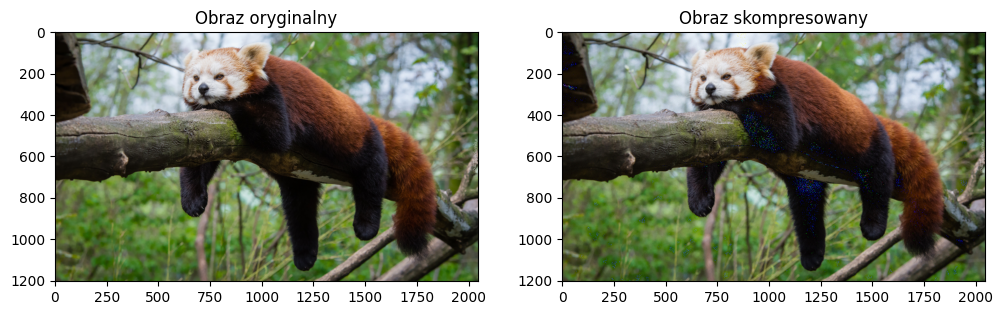

Mean Absolute Error: 2.8255300304752806
Commpression Ratio (C): 1.0


In [246]:
color_image = io.imread("pandaaa.jpg")
compressed_color = compress_RGB(color_image,0.1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(color_image)
plt.title("Obraz oryginalny")


plt.subplot(1,2,2)
plt.imshow(np.uint8(compressed_color))
plt.title("Obraz skompresowany")
plt.show()
print(f"Mean Absolute Error: {MAE(color_image,compressed_color)}")
print(f"Commpression Ratio (C): {C_ratio(color_image,np.uint8(compressed_color))}")

# Algorytm kompresji stratnej korzystający z transformacji falkowej dla obrazów szarych

In [247]:
def wavelet_compress(image, compression_ratio):
    img = np.array(image)
    # transformacja falkowa 2D
    coeffs = pywt.dwt2(img,"bior1.3")
    cA, (cH, cV, cD) = coeffs # Odpowiednio w kolejności współczynniki przybliżenia, horyzontalny, pionowy oraz diagonalny
    # Zmniejszenie liczby współczynników
    threshold = np.max(np.abs(cD)) * compression_ratio / 10.0 # Dzielnie należy dostosować w zależności od potrzeb
    cD_threshold = pywt.threshold(cD, threshold, mode="soft")
    # Odwrotna transformacja falkowa
    coeefs_threshold = (cA,(cH, cV, cD_threshold))
    output = pywt.idwt2(coeefs_threshold, "bior1.3")
    return output

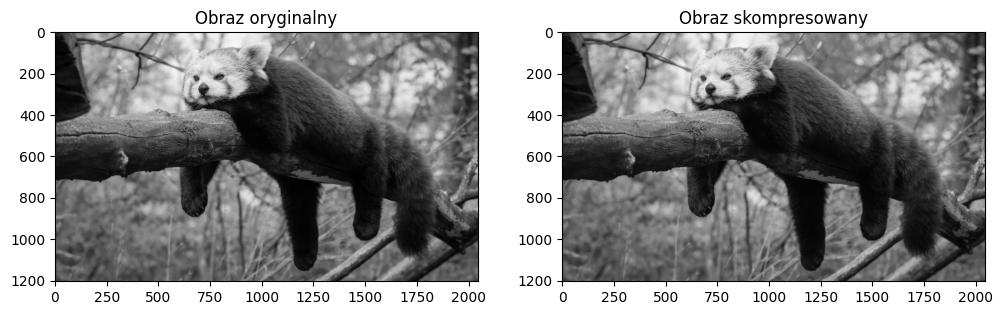

Mean Absolute Error: 0.0017552369191965122
Commpression Ratio (C): 1.0


In [248]:
wavelet_compressed_image = wavelet_compress(image_gray, 0.3)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image_gray, cmap="gray")
plt.title("Obraz oryginalny")


plt.subplot(1,2,2)
plt.imshow(wavelet_compressed_image,cmap="gray")
plt.title("Obraz skompresowany")
plt.show()
print(f"Mean Absolute Error: {MAE(image_gray,wavelet_compressed_image)}")
print(f"Commpression Ratio (C): {C_ratio(image_gray,wavelet_compressed_image)}")

# Algorytm kompresji stratnej korzystający z transformacji falkowej dla obrazów kolorowych

Koniecznym modyfikacjom podlega jedynie implementacja kompresji dla poszczególnych kanałów barwnych, tj. czerwonego (R), zielonego (G) oraz niebieskiego (B).

In [249]:
def wavelet_compress_color(image, compression_ratio):
    img_compress = np.zeros_like(image, dtype=np.uint8)
    # transformacja falkowa 2D dla każdego kanału
    for channel in range(3):
        coeffs = pywt.dwt2(image[:,:,channel],"bior1.3")
        cA, (cH, cV, cD) = coeffs # Odpowiednio w kolejności współczynniki przybliżenia, horyzontalny, pionowy oraz diagonalny
        # Zmniejszenie liczby współczynników
        threshold = np.max(np.abs(cD)) * compression_ratio / 10.0 # Dzielnie należy dostosować w zależności od potrzeb
        cD_threshold = pywt.threshold(cD, threshold, mode="soft")
        # Odwrotna transformacja falkowa
        coeefs_threshold = (cA,(cH, cV, cD_threshold))
        img_compress[:,:,channel] = pywt.idwt2(coeefs_threshold, "bior1.3")
    return img_compress

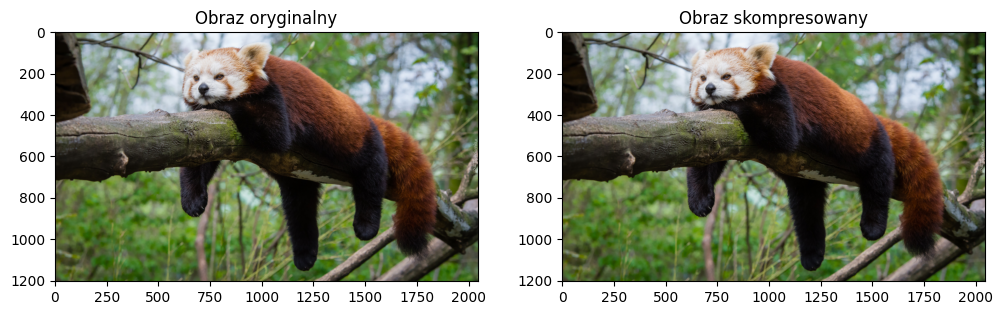

Mean Absolute Error: 0.48819276037907994
Commpression Ratio (C): 1.0


In [250]:
wavelet_compressed_image_color = wavelet_compress_color(color_image, 0.01)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(color_image, cmap="gray")
plt.title("Obraz oryginalny")


plt.subplot(1,2,2)
plt.imshow(wavelet_compressed_image_color,cmap="gray")
plt.title("Obraz skompresowany")
plt.show()
print(f"Mean Absolute Error: {MAE(color_image,wavelet_compressed_image_color)}")
print(f"Commpression Ratio (C): {C_ratio(color_image,wavelet_compressed_image_color)}")

# Algorytm kompresji stratnej korzystającej z transformacji cosinusowej.

In [262]:
def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

def idct2a(image):
    return idct(idct(image.T,norm='ortho').T, norm='ortho')

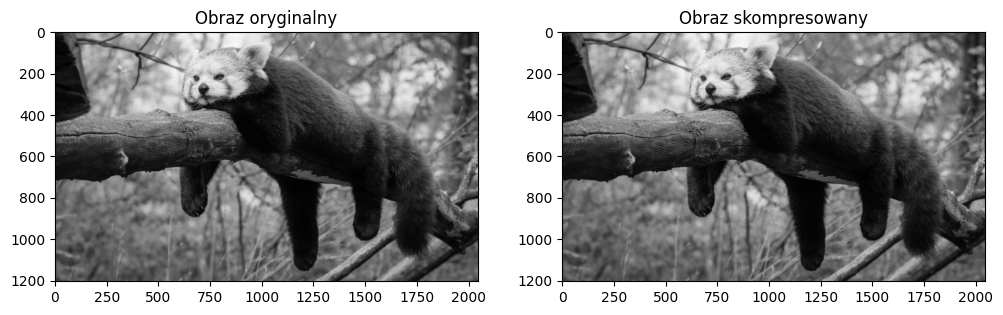

Mean Absolute Error: 2.314647208962396e-16
Commpression Ratio (C): 1.0


In [263]:
imF = dct2(image_gray)
im1 = idct2a(imF)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image_gray, cmap="gray")
plt.title("Obraz oryginalny")


plt.subplot(1,2,2)
plt.imshow(im1,cmap="gray")
plt.title("Obraz skompresowany")
plt.show()
print(f"Mean Absolute Error: {MAE(image_gray,im1)}")
print(f"Commpression Ratio (C): {C_ratio(image_gray,im1)}")

# 